In [11]:
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
import os

from scipy.spatial import distance as dist

from io import BytesIO
from IPython.display import display, Image, clear_output
from PIL import Image as Img

In [12]:
def image_pattern(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (800, 600))
    return frame

In [13]:
def show_video(frame):
    img = Img.fromarray(frame, 'RGB')
    buffer = BytesIO()
    img.save(buffer, format='JPEG')
    display(Image(data=buffer.getvalue()))
    clear_output(wait=True)

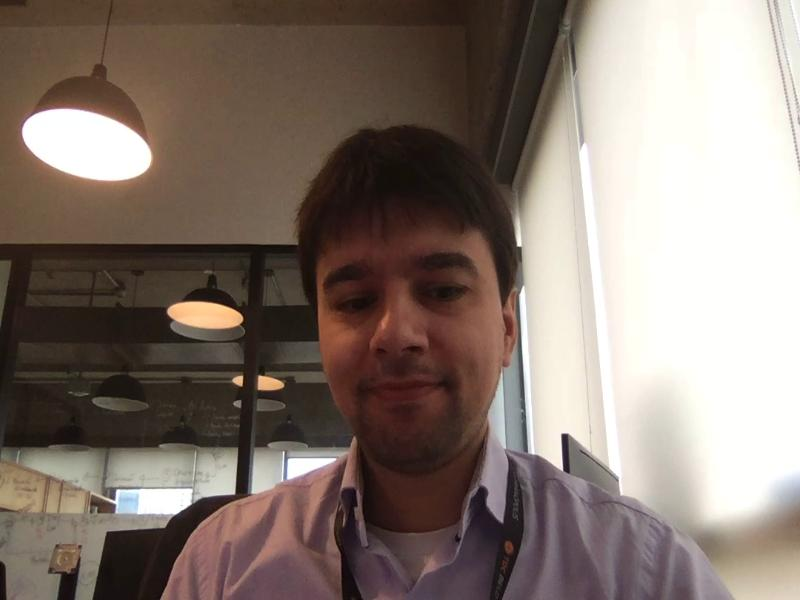

In [14]:
video = cv2.VideoCapture("videos/expressoes.mov")

try:
    while True:
        capture_ok, frame = video.read()
        if not capture_ok:
            break

        frame = image_pattern(frame)
        show_video(frame)
except KeyboardInterrupt:
    video.release()
    clear_output(wait=True)

In [15]:
dblib_68_classifier_path = "shape_predictor_68_face_landmarks.dat"
dlib_classifier = dlib.shape_predictor(dblib_68_classifier_path)
dlib_face_detector = dlib.get_frontal_face_detector()

In [16]:
face = list(range(17, 68))
complete_face = list(range(0, 68))
lips = list(range(48, 61))
left_eyebrows = list(range(22, 27))
right_eyebrows = list(range(17, 22))
right_eye = list(range(36, 42))
left_eye = list(range(42, 48))
nose = list(range(27, 35))
jaw = list(range(0, 17))

In [28]:
def contouring_face(img):
    rectangles = dlib_face_detector(img, 1)

    if len(rectangles) == 0:
        return [], img
    
    for k, d in enumerate(rectangles):
        cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), (255, 0, 255), 2)
    
    return rectangles, img

In [29]:
def facial_marks_points (img):
    rectangles, _= contouring_face(img)

    if len(rectangles) is None:
        return None
    
    marks = []

    for ret in rectangles:
       marks.append(np.matrix ([[p.x, p.y] for p in dlib_classifier(img, ret).parts()]))

    return marks

In [30]:
def reason_aspect_mouth(mouth_points):
    mouth_points = np.squeeze(np.array(mouth_points))
    if mouth_points.ndim != 2 or mouth_points.shape[1] != 2:
        raise ValueError("Input vector should be 2-D with shape (n, 2).")
    
    a = dist.euclidean(mouth_points[3], mouth_points[9])
    b = dist.euclidean(mouth_points[2], mouth_points[10])
    c = dist.euclidean(mouth_points[4], mouth_points[8])
    d = dist.euclidean(mouth_points[0], mouth_points[6])

    reason_aspect = (a + b + c) / (3.0 * d)

    return reason_aspect

In [31]:
def annotate_convex_shell_marks_mouth(img, marks):
    result = contouring_face(img)
    
    rectangles, _ = result
    
    if len(rectangles) == 0:
        return None
    
    for idx, ret in enumerate(rectangles):
        mark = marks[idx]

        points = cv2.convexHull(mark[lips])
        cv2.drawContours(img, [points], 0, (0, 255, 0), 2)

    return img

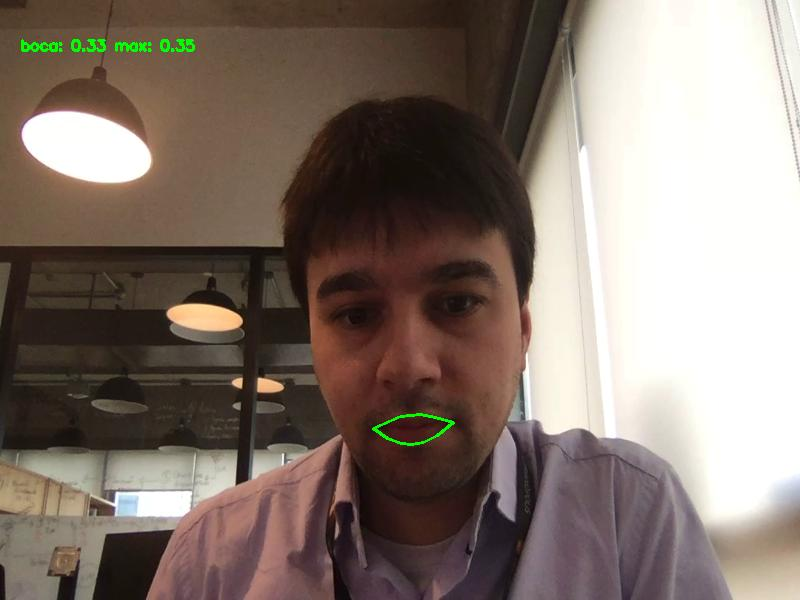

In [34]:
try:
    ar_max = 0
    video = cv2.VideoCapture("videos/bocejo.mov")

    while True:
        capture_ok, frame = video.read()
        if not capture_ok:
            break

        frame = image_pattern(frame)
        result = facial_marks_points(frame)

        if result is None:
            continue

        ar_mouth = reason_aspect_mouth(np.squeeze(result[0][lips]))
        ar_mouth = round(ar_mouth, 2)

        if ar_mouth > ar_max:
            ar_max = ar_mouth

        info = "boca: {:.2f}".format(ar_mouth) + " max: {:.2f}".format(ar_max)

        frame = annotate_convex_shell_marks_mouth(frame, result)

        cv2.putText(frame, info, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        show_video(frame)
        
except KeyboardInterrupt:
    video.release()
    clear_output(wait=True)

In [35]:
def eye_aspect_ratio(eye):

    eye = np.squeeze(np.asarray(eye))
    
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    
    ear = (A + B) / (2.0 * C)
    return ear

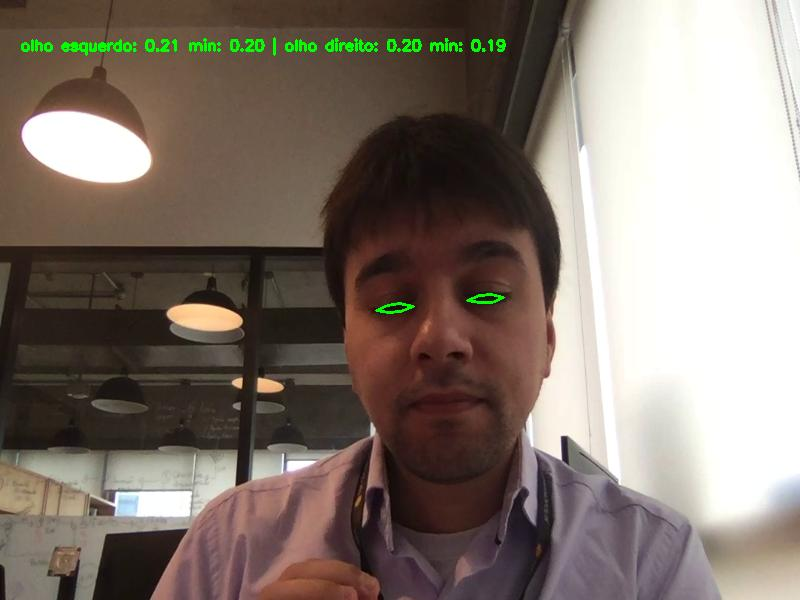

In [40]:
def annotate_convex_shell_marks_eyes(img, marks):
    rectangles, _ = contouring_face(img)
    
    if len(rectangles) == 0:
        return None
    
    for idx, ret in enumerate(rectangles):
        mark = marks[idx]

        left_eye_points = cv2.convexHull(mark[left_eye])
        right_eye_points = cv2.convexHull(mark[right_eye])
        
        cv2.drawContours(img, [left_eye_points], 0, (0, 255, 0), 2)
        cv2.drawContours(img, [right_eye_points], 0, (0, 255, 0), 2)

    return img

try:
    min_left_eye = 1
    min_right_eye = 1  

    video = cv2.VideoCapture("videos/olhos-fechados.mov")

    while True:
        capture_ok, frame = video.read()
        frame = image_pattern(frame)

        facial_marks = facial_marks_points(frame)

        if facial_marks is None:
            continue

        ar_left_eye = eye_aspect_ratio(np.squeeze(facial_marks[0][left_eye]))
        ar_right_eye = eye_aspect_ratio(np.squeeze(facial_marks[0][right_eye]))

        ar_left_eye = round(ar_left_eye, 3)
        ar_right_eye = round(ar_right_eye, 3)

        if ar_left_eye < min_left_eye:
            min_left_eye = ar_left_eye

        if ar_right_eye < min_right_eye:
            min_right_eye = ar_right_eye

        info = "olho esquerdo: {:.2f}".format(ar_left_eye) + " min: {:.2f}".format(min_left_eye) + " | " + "olho direito: {:.2f}".format(ar_right_eye) + " min: {:.2f}".format(min_right_eye)

        frame = annotate_convex_shell_marks_eyes(frame, facial_marks)

        cv2.putText(frame, info, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        show_video(frame)

except KeyboardInterrupt:
    video.release()
    clear_output(wait=True)